In [ ]:
# Rendu final – Approches quantitatives et modélisation mathématique
# Titre du projet : Évolution thématique de la presse française (1950–1970): une approche quantitative et diachronique
# Susanna De Luca – Master 2 Humanités Numériques – Janvier 2026


In [ ]:
# 1) Chargement du corpus en mode streaming (rapide et léger)
# Le dataset complet est très volumineux. Le mode "streaming" permet
# de lire les données progressivement, sans tout télécharger ni saturer la RAM.

!pip install -q datasets

from datasets import load_dataset

ds_stream = load_dataset("PleIAs/French-PD-Newspapers", split="train", streaming=True)

# Test rapide : on récupère 1 exemple pour vérifier les champs disponibles
ex = next(iter(ds_stream))
print(ex.keys())


Resolving data files:   0%|          | 0/320 [00:00<?, ?it/s]

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 3b542298-7147-4d30-8329-4db5cc55091d)')' thrown while requesting GET https://huggingface.co/datasets/PleIAs/French-PD-Newspapers/resolve/b1ce8d95cb66432879a34cdedfda9a0dad478204/gallica_presse_1.parquet
Retrying in 1s [Retry 1/5].


dict_keys(['file_id', 'ocr', 'title', 'date', 'author', 'page_count', 'word_count', 'character_count', 'complete_text'])


In [ ]:
# 2) Construction d’un sous-corpus équilibré (1950s / 1960s / 1970s)
# Principe :
# On lit le dataset en streaming (sans télécharger tout le corpus).
# On extrait l'année (robuste) depuis la chaîne "date" grâce à une regex.
# On remplit des quotas par décennie (100 + 100 + 100).
# On stocke immédiatement "annee" et "decennie" dans chaque enregistrement.

import re
import time
import pandas as pd

def extraire_annee(valeur):
    """Extrait une année (4 chiffres) depuis une chaîne, sinon None."""
    if valeur is None:
        return None
    m = re.search(r"(18|19|20)\d{2}", str(valeur))
    return int(m.group(0)) if m else None

quotas = {
    "1950s": {"min": 1950, "max": 1959, "target": 100, "count": 0},
    "1960s": {"min": 1960, "max": 1969, "target": 100, "count": 0},
    "1970s": {"min": 1970, "max": 1979, "target": 100, "count": 0},
}

selection = []
lus = 0

it = iter(ds_stream)

while True:
    try:
        ex = next(it)
        lus += 1

        annee = extraire_annee(ex.get("date", None))
        if annee is None:
            continue

        # Remplissage des quotas
        for decade, cfg in quotas.items():
            if cfg["min"] <= annee <= cfg["max"] and cfg["count"] < cfg["target"]:
                ex2 = dict(ex)  # copie
                ex2["annee"] = annee
                ex2["decennie"] = decade
                selection.append(ex2)
                cfg["count"] += 1
                break

        # Suivi léger
        if lus % 5000 == 0:
            print("Lus :", lus, "| Sélection :", len(selection),
                  "| Quotas :", {k: v["count"] for k, v in quotas.items()})

        # Arrêt
        if all(cfg["count"] >= cfg["target"] for cfg in quotas.values()):
            break

    except StopIteration:
        break
    except Exception as e:
        # En cas de micro-coupure réseau, on attend puis on continue
        print("Avertissement (réseau/lecture) :", repr(e))
        time.sleep(2)
        continue

df = pd.DataFrame(selection)

print("Taille du corpus :", len(df))
print("Répartition par décennie :")
print(df["decennie"].value_counts().sort_index())

df[["date", "annee", "decennie", "title", "word_count"]].head(5)


Lus : 5000 | Sélection : 69 | Quotas : {'1950s': 29, '1960s': 20, '1970s': 20}
Lus : 10000 | Sélection : 152 | Quotas : {'1950s': 53, '1960s': 48, '1970s': 51}
Lus : 15000 | Sélection : 222 | Quotas : {'1950s': 88, '1960s': 62, '1970s': 72}
Lus : 20000 | Sélection : 283 | Quotas : {'1950s': 100, '1960s': 91, '1970s': 92}
Taille du corpus : 300
Répartition par décennie :
decennie
1950s    100
1960s    100
1970s    100
Name: count, dtype: int64


date  annee decennie  \
0  1952-11-01   1952    1950s   
1  1969-08-15   1969    1960s   
2  1957-12-15   1957    1950s   
3  1950-09-05   1950    1950s   
4  1959-03-17   1959    1950s   

                                               title  word_count  
0                                  Aviation magazine       27805  
1                                    France-aviation       21045  
2  Les Jeunes : courrier de quinzaine du journal ...        9344  
3  La Croix du Nord : supplément régional à la Cr...       35193  
4  Recueil des actes administratifs de la Délégat...       30743

In [ ]:
# 3) Sauvegarde du sous-corpus (fichier unique)
# Objectif : sauvegarder le corpus final dans un seul fichier CSV,
# afin de poursuivre l'analyse sans dépendre du streaming.

fichier_sortie = "corpus_presse_fr_1950s_1960s_1970s_300.csv"

# On garde les colonnes utiles
colonnes_utiles = [
    "file_id", "title", "date", "annee", "decennie", "author",
    "word_count", "character_count", "complete_text"
]

df[colonnes_utiles].to_csv(fichier_sortie, index=False)

print("Fichier créé :", fichier_sortie)
print("Taille (lignes) :", len(df))


Fichier créé : corpus_presse_fr_1950s_1960s_1970s_300.csv
Taille (lignes) : 300


In [ ]:
# 4) Chargement du fichier CSV (corpus final) + contrôles de base
# Objectif : charger le sous-corpus sauvegardé (300 articles),
# vérifier la structure (colonnes), la taille, et l'absence de
# valeurs manquantes critiques pour l'analyse.

import pandas as pd

# Chargement du corpus depuis le fichier unique
chemin_fichier = "corpus_presse_fr_1950s_1960s_1970s_300.csv"
df = pd.read_csv(chemin_fichier)

# Contrôles rapides
print("Taille du corpus (lignes, colonnes) :", df.shape)
print("\nColonnes disponibles :")
print(list(df.columns))

print("\nValeurs manquantes (top 10) :")
print(df.isna().sum().sort_values(ascending=False).head(10))

# Aperçu
df[["date", "annee", "decennie", "title", "word_count"]].head(5)


Taille du corpus (lignes, colonnes) : (300, 9)

Colonnes disponibles :
['file_id', 'title', 'date', 'annee', 'decennie', 'author', 'word_count', 'character_count', 'complete_text']

Valeurs manquantes (top 10) :
author             49
file_id             0
title               0
annee               0
date                0
decennie            0
word_count          0
character_count     0
complete_text       0
dtype: int64


date  annee decennie  \
0  1952-11-01   1952    1950s   
1  1969-08-15   1969    1960s   
2  1957-12-15   1957    1950s   
3  1950-09-05   1950    1950s   
4  1959-03-17   1959    1950s   

                                               title  word_count  
0                                  Aviation magazine       27805  
1                                    France-aviation       21045  
2  Les Jeunes : courrier de quinzaine du journal ...        9344  
3  La Croix du Nord : supplément régional à la Cr...       35193  
4  Recueil des actes administratifs de la Délégat...       30743

Répartition par décennie :
decennie
1950s    100
1960s    100
1970s    100
Name: count, dtype: int64


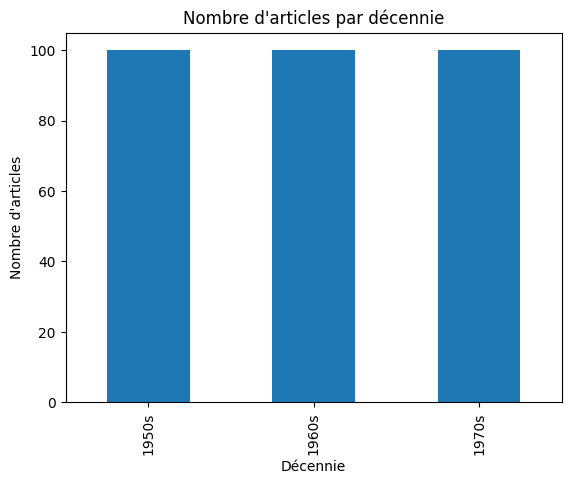


Statistiques word_count :
count       300.000000
mean      36202.276667
std       67424.294070
min         253.000000
25%        9291.000000
50%       21691.000000
75%       39869.250000
max      997600.000000
Name: word_count, dtype: float64


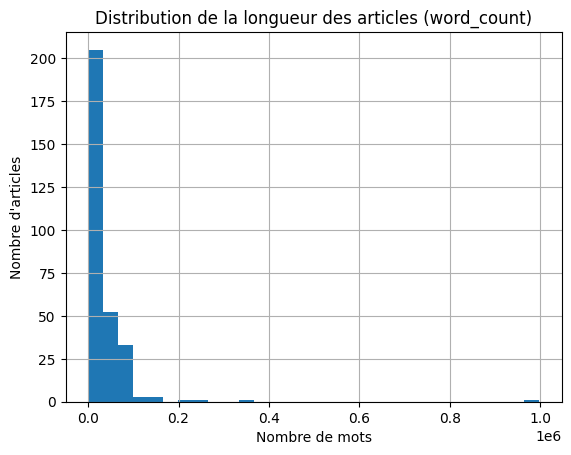

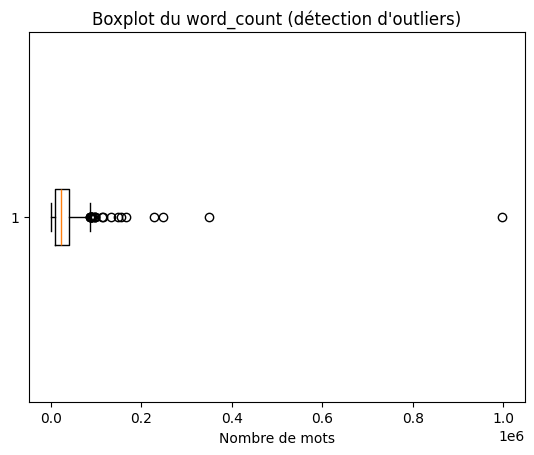

In [ ]:
# 5) Statistiques descriptives et premières visualisations
# Objectif : décrire le corpus (répartition temporelle, longueur des textes)
# et repérer d'éventuels outliers (textes très courts ou très longs).

import matplotlib.pyplot as plt

# Répartition par décennie (devrait être équilibrée)
rep_dec = df["decennie"].value_counts().sort_index()
print("Répartition par décennie :")
print(rep_dec)

plt.figure()
rep_dec.plot(kind="bar")
plt.title("Nombre d'articles par décennie")
plt.xlabel("Décennie")
plt.ylabel("Nombre d'articles")
plt.show()

# Statistiques sur la longueur (word_count)
print("\nStatistiques word_count :")
print(df["word_count"].describe())

plt.figure()
df["word_count"].hist(bins=30)
plt.title("Distribution de la longueur des articles (word_count)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.show()

# Boxplot pour visualiser les outliers
plt.figure()
plt.boxplot(df["word_count"], vert=False)
plt.title("Boxplot du word_count (détection d'outliers)")
plt.xlabel("Nombre de mots")
plt.show()


Taille originale : 300
Taille après filtrage : 292

Distribution des longueurs :
count       292.000000
mean      29841.006849
std       26786.454185
min        1077.000000
25%        9291.000000
50%       21477.000000
75%       38539.750000
max      148417.000000
Name: word_count, dtype: float64


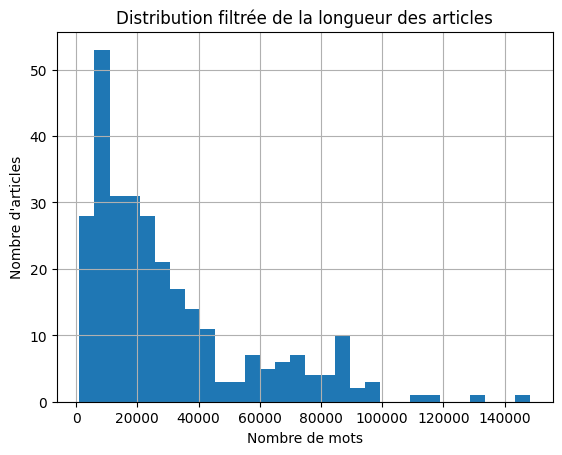

In [ ]:
# 6) Filtrage des articles trop courts ou anormalement longs
# Objectif : supprimer les textes aberrants (OCR massifs) et
# éliminer les fragments trop courts pour une analyse fiable.

min_words = 800      # seuil minimum raisonnable
max_words = 150000   # seuil maximum pour éliminer les OCR monstrueux

df_filtre = df[(df["word_count"] >= min_words) & (df["word_count"] <= max_words)].copy()

print("Taille originale :", len(df))
print("Taille après filtrage :", len(df_filtre))
print("\nDistribution des longueurs :")
print(df_filtre["word_count"].describe())

# graphique mis à jour
df_filtre["word_count"].hist(bins=30)
plt.title("Distribution filtrée de la longueur des articles")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.show()


In [ ]:
# 7) Prétraitement linguistique de base (français)
# Objectif : normaliser les textes pour l'analyse quantitative :
# minuscules, suppression de la ponctuation, suppression des chiffres isolés, suppression des stopwords français

import re
import nltk
from nltk.corpus import stopwords

# Téléchargement des stopwords français (une seule fois)
nltk.download("stopwords")

stopwords_fr = set(stopwords.words("french"))

def nettoyer_texte(texte):
    if not isinstance(texte, str):
        return ""

    # Passage en minuscules
    texte = texte.lower()

    # Suppression des chiffres
    texte = re.sub(r"\d+", " ", texte)

    # Suppression de la ponctuation
    texte = re.sub(r"[^\w\s]", " ", texte)

    # Suppression des espaces multiples
    texte = re.sub(r"\s+", " ", texte).strip()

    # Suppression des stopwords
    tokens = texte.split()
    tokens = [t for t in tokens if t not in stopwords_fr and len(t) > 2]

    return " ".join(tokens)

# Application du nettoyage
df_filtre["texte_nettoye"] = df_filtre["complete_text"].apply(nettoyer_texte)

# Contrôles
print("Exemple de texte original :\n")
print(df_filtre["complete_text"].iloc[0][:500])

print("\nExemple de texte nettoyé :\n")
print(df_filtre["texte_nettoye"].iloc[0][:500])

print("\nLongueur moyenne après nettoyage (en mots) :")
print(df_filtre["texte_nettoye"].apply(lambda x: len(x.split())).mean())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Exemple de texte original :


c jùan&amp; ce numézc : 
EXERCICES DE JOUR ET DE NUIT 
BELGIQUE: 20 F " SUISSE: 2 F " 
 
AVENUE MARCEAU PARIS VIII 
 
COURRIER 
Dans votre numéro 60 du 15 octobre dernier, vous avez consacré, page 23, quelques lignes au Farman F.40. Je me permets de vous signaler que la tusion Henri et Maurice Farman était accomplie avant la guerre de 1914. Le F.40 a été construit par les usines de Billancourt et également à l'annexe de Lyon, au début de 1916, comme vous l'indiquez. Cet avion était un amalgame 

Exemple de texte nettoyé :

jùan amp numézc exercices jour nuit belgique suisse avenue marceau paris viii courrier numéro octobre dernier consacré page quelques lignes farman permets signaler tusion henri maurice farman accomplie avant guerre construit usines billancourt également annexe lyon début comme indiquez cet avion amalgame farman cellule tuselage moteur renault farman dont tenait plan surélevé liaison cellule plan tubes métalliques disposés façon former pi

In [ ]:
# 8) Représentation vectorielle des textes : TF-IDF
# Objectif :
# Transformer les textes nettoyés en une matrice document-terme
# pondérée par TF-IDF (Term Frequency – Inverse Document Frequency).
# Cette représentation permet de mettre en valeur les termes discriminants et constitue la base du topic modeling et des analyses ultérieures.

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialisation du vectoriseur TF-IDF
vectorizer = TfidfVectorizer(
    max_df=0.9,        # exclut les termes trop fréquents (peu discriminants)
    min_df=5,          # exclut les termes trop rares
    max_features=5000  # limite la taille du vocabulaire
)

# Construction de la matrice TF-IDF
X_tfidf = vectorizer.fit_transform(df_filtre["texte_nettoye"])

# Contrôles
print("Dimensions de la matrice TF-IDF (documents × termes) :", X_tfidf.shape)

termes = vectorizer.get_feature_names_out()
print("Nombre de termes retenus :", len(termes))
print("Exemples de termes :", termes[:20])


Dimensions de la matrice TF-IDF (documents × termes) : (292, 5000)
Nombre de termes retenus : 5000
Exemples de termes : ['abandon' 'abandonner' 'abbaye' 'abbé' 'abondance' 'abonnement'
 'abonnements' 'abonnés' 'abord' 'aborder' 'aboutir' 'aboutit' 'abraham'
 'abri' 'abrégé' 'absence' 'absolue' 'absolument' 'absorption' 'académie']


In [ ]:
# 9) Topic modeling avec Non-negative Matrix Factorization (NMF)
# Objectif :
# Identifier des thématiques latentes dans le corpus à partir de la matrice TF-IDF, en utilisant la factorisation NMF.

from sklearn.decomposition import NMF
import numpy as np

# Nombre de topics
n_topics = 10

# Initialisation du modèle NMF
nmf_model = NMF(
    n_components=n_topics,
    random_state=42,
    init="nndsvd",
    max_iter=500
)

# Apprentissage du modèle
W = nmf_model.fit_transform(X_tfidf)  # documents × topics
H = nmf_model.components_             # topics × termes

print("Dimensions W (documents × topics) :", W.shape)
print("Dimensions H (topics × termes) :", H.shape)

# Affichage des mots-clés pour chaque topic
n_top_words = 12

feature_names = termes

for topic_idx, topic in enumerate(H):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_terms = [feature_names[i] for i in top_indices]
    print(f"\nTopic {topic_idx + 1} :")
    print(", ".join(top_terms))


Dimensions W (documents × topics) : (292, 10)
Dimensions H (topics × termes) : (10, 5000)

Topic 1 :
sociale, social, vie, formation, politique, aussi, enfants, action, sociales, problèmes, faut, sociaux

Topic 2 :
seine, préfet, municipal, police, art, préfecture, ville, arrondissement, heures, arrêté, publique, conseillers

Topic 3 :
dieu, jésus, christ, salut, vie, bible, homme, armée, monde, major, seigneur, foi

Topic 4 :
sport, pts, ligue, sportive, fédération, club, championnats, fédéral, athlétisme, clubs, jeunes, sports

Topic 5 :
arrêté, décret, algérie, échelon, art, classe, compter, article, portant, décembre, janvier, chef

Topic 6 :
air, avion, aéro, vol, aviation, passagers, club, pilote, appareil, moteur, vitesse, fret

Topic 7 :
siècle, aussi, histoire, peu, société, vers, église, quelques, abbé, orléans, pierre, roi

Topic 8 :
importations, exportations, ffl, produits, production, indice, moy, indices, etranger, total, franc, trim

Topic 9 :
the, and, fig, eau, eaux, 

Exemples de topics dominants :
  decennie  topic_dominant
0    1950s               5
1    1960s               5
2    1950s               3
3    1950s               6
4    1950s               4

Tableau croisé (topics × décennies) :
topic_dominant   0   1   2  3   4   5   6  7   8  9
decennie                                           
1950s            4   8   7  9  23   9  28  2   6  1
1960s           10  27   9  9   8   7  20  4   4  2
1970s           22   0  11  5   1  10  31  3  10  2

Tableau croisé normalisé (proportion par décennie) :
topic_dominant         0         1         2         3         4         5  \
decennie                                                                     
1950s           0.041237  0.082474  0.072165  0.092784  0.237113  0.092784   
1960s           0.100000  0.270000  0.090000  0.090000  0.080000  0.070000   
1970s           0.231579  0.000000  0.115789  0.052632  0.010526  0.105263   

topic_dominant         6         7         8         9  
decenn

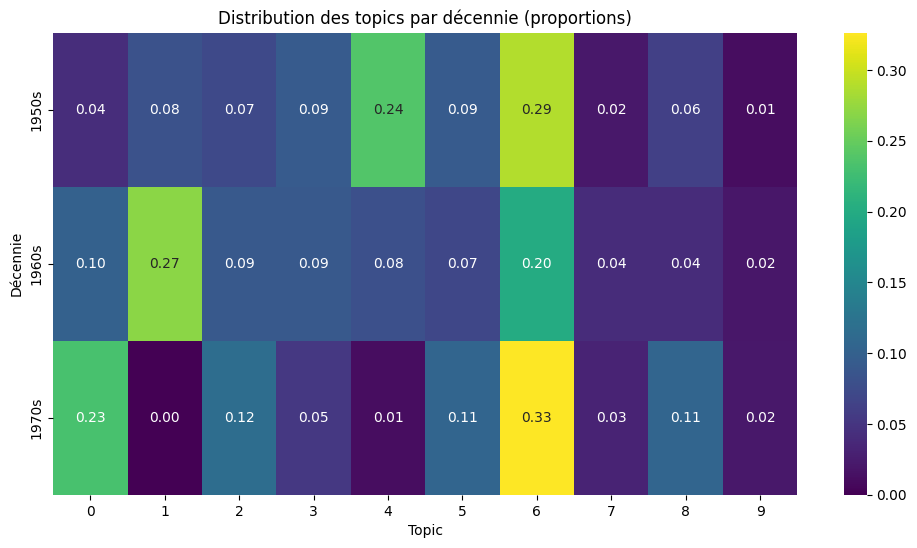

In [ ]:
# 10) Attribution du topic dominant et analyse temporelle
# Objectif :
# Associer à chaque article le topic le plus probable (topic dominant) à partir de la matrice W.
# Calculer la distribution des topics dans chaque décennie.
# Visualiser les variations thématiques à l'aide d'une heatmap.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Attribution du topic dominant pour chaque article
df_filtre["topic_dominant"] = W.argmax(axis=1)

print("Exemples de topics dominants :")
print(df_filtre[["decennie", "topic_dominant"]].head())

# 2) Tableau croisé : distribution (topics × décennies)
table_topics = pd.crosstab(df_filtre["decennie"], df_filtre["topic_dominant"])

print("\nTableau croisé (topics × décennies) :")
print(table_topics)

# Normalisation par ligne (% sur chaque décennie)
table_topics_norm = table_topics.div(table_topics.sum(axis=1), axis=0)

print("\nTableau croisé normalisé (proportion par décennie) :")
print(table_topics_norm)

# 3) Heatmap de la distribution des topics par décennie
plt.figure(figsize=(12, 6))
sns.heatmap(table_topics_norm, annot=True, cmap="viridis", fmt=".2f")
plt.title("Distribution des topics par décennie (proportions)")
plt.xlabel("Topic")
plt.ylabel("Décennie")
plt.show()


In [ ]:
# 11) Extraction des mots-clés caractérisant chaque topic
# Objectif :
# Identifier les 15 termes les plus représentatifs par topic
# Faciliter l'interprétation qualitative du modèle

n_top_words = 15

print("Mots-clés les plus représentatifs par topic :\n")

for topic_idx, topic in enumerate(H):
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    print(f"Topic {topic_idx+1} : {', '.join(top_terms)}\n")


Mots-clés les plus représentatifs par topic :

Topic 1 : sociale, social, vie, formation, politique, aussi, enfants, action, sociales, problèmes, faut, sociaux, travailleurs, congrès, donc

Topic 2 : seine, préfet, municipal, police, art, préfecture, ville, arrondissement, heures, arrêté, publique, conseillers, question, mairie, personnel

Topic 3 : dieu, jésus, christ, salut, vie, bible, homme, armée, monde, major, seigneur, foi, père, dimanche, amour

Topic 4 : sport, pts, ligue, sportive, fédération, club, championnats, fédéral, athlétisme, clubs, jeunes, sports, bat, commission, basket

Topic 5 : arrêté, décret, algérie, échelon, art, classe, compter, article, portant, décembre, janvier, chef, loi, mer, fixant

Topic 6 : air, avion, aéro, vol, aviation, passagers, club, pilote, appareil, moteur, vitesse, fret, aéronautique, compagnies, compagnie

Topic 7 : siècle, aussi, histoire, peu, société, vers, église, quelques, abbé, orléans, pierre, roi, rabelais, lille, mme

Topic 8 : impo

In [ ]:
# 12) Conclusion quantitative et sauvegarde des résultats
# Objectif :
# Résumer les principaux résultats quantitatifs
# Sauvegarder le corpus enrichi (topics, décennie, texte nettoyé)

# Résumé quantitatif
print("Résumé du corpus final :")
print("Nombre total d'articles :", len(df_filtre))
print("Décennies étudiées :", df_filtre['decennie'].unique())
print("Nombre de topics :", n_topics)

print("\nDistribution globale des topics :")
print(df_filtre["topic_dominant"].value_counts().sort_index())

# Sauvegarde du corpus enrichi
colonnes_a_sauver = [
    "file_id",
    "title",
    "date",
    "annee",
    "decennie",
    "author",
    "word_count",
    "topic_dominant",
    "texte_nettoye"
]

fichier_sortie = "corpus_presse_fr_topics_1950s_1960s_1970s.csv"
df_filtre[colonnes_a_sauver].to_csv(fichier_sortie, index=False)

print("\nFichier sauvegardé :", fichier_sortie)


Résumé du corpus final :
Nombre total d'articles : 292
Décennies étudiées : ['1950s' '1960s' '1970s']
Nombre de topics : 10

Distribution globale des topics :
topic_dominant
0    36
1    35
2    27
3    23
4    32
5    26
6    79
7     9
8    20
9     5
Name: count, dtype: int64

Fichier sauvegardé : corpus_presse_fr_topics_1950s_1960s_1970s.csv


Dataframe utilisé : df_filtre | Taille : (292, 11)
Colonne texte utilisée : texte_nettoye
Nombre de caractères (texte agrégé) : 35557780


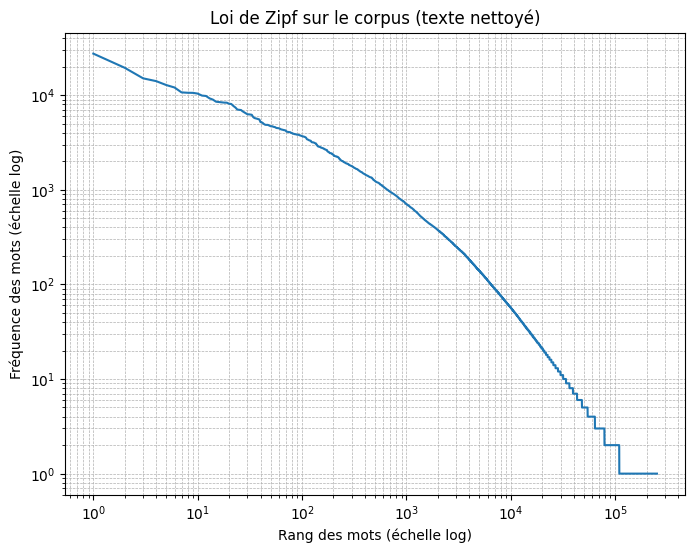


Nombre total de tokens : 4438419
Nombre de types (vocabulaire unique) : 251629

20 mots les plus fréquents :
                plus  27491
               cette  19468
                être  15064
               paris  14075
               comme  12796
                deux  12053
              france  10703
                fait  10602
                dont  10580
                tout  10391
                bien  9899
                peut  9809
                sans  9252
                 rue  8971
               après  8528
                très  8459
                sous  8403
               entre  8342
                tous  8332
             général  8116


In [ ]:
# 13) Analyse linguistique : loi de Zipf (version robuste)
# Objectif : visualiser la distribution rang–fréquence des mots (log–log) sur le corpus nettoyé.

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- 1) Choix du dataframe (df_filtre est attendu, sinon on tente df) ---
if "df_filtre" in globals():
    _df = df_filtre.copy()
    df_name = "df_filtre"
elif "df" in globals():
    _df = df.copy()
    df_name = "df"
else:
    raise NameError("Aucun dataframe trouvé : ni 'df_filtre' ni 'df'. Relance la cellule de chargement/filtrage.")

# --- 2) Choix de la colonne texte nettoyé (selon l'orthographe) ---
possible_cols = ["texte_nettoye", "texte_nettoyé", "clean_text", "text_clean"]
text_col = next((c for c in possible_cols if c in _df.columns), None)

if text_col is None:
    raise KeyError(
        "Colonne de texte nettoyé introuvable. Colonnes disponibles :\n"
        + ", ".join(_df.columns)
        + "\nAttendu : 'texte_nettoye' (ou 'texte_nettoyé')."
    )

# --- 3) Construction des tokens (en gérant les NaN) ---
texts = _df[text_col].fillna("").astype(str).tolist()
joined = " ".join(texts).strip()

print("Dataframe utilisé :", df_name, "| Taille :", _df.shape)
print("Colonne texte utilisée :", text_col)
print("Nombre de caractères (texte agrégé) :", len(joined))

if len(joined) == 0:
    raise ValueError("Le texte agrégé est vide : la colonne de texte nettoyé ne contient rien après nettoyage.")

all_tokens = joined.split()

# --- 4) Fréquences et Zipf ---
freqs = Counter(all_tokens)

sorted_freqs = np.array(sorted(freqs.values(), reverse=True))
ranks = np.arange(1, len(sorted_freqs) + 1)

plt.figure(figsize=(8, 6))
plt.loglog(ranks, sorted_freqs)
plt.xlabel("Rang des mots (échelle log)")
plt.ylabel("Fréquence des mots (échelle log)")
plt.title("Loi de Zipf sur le corpus (texte nettoyé)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# --- 5) Indicateurs ---
print("\nNombre total de tokens :", len(all_tokens))
print("Nombre de types (vocabulaire unique) :", len(freqs))

print("\n20 mots les plus fréquents :")
for w, c in freqs.most_common(20):
    print(f"{w:>20s}  {c}")


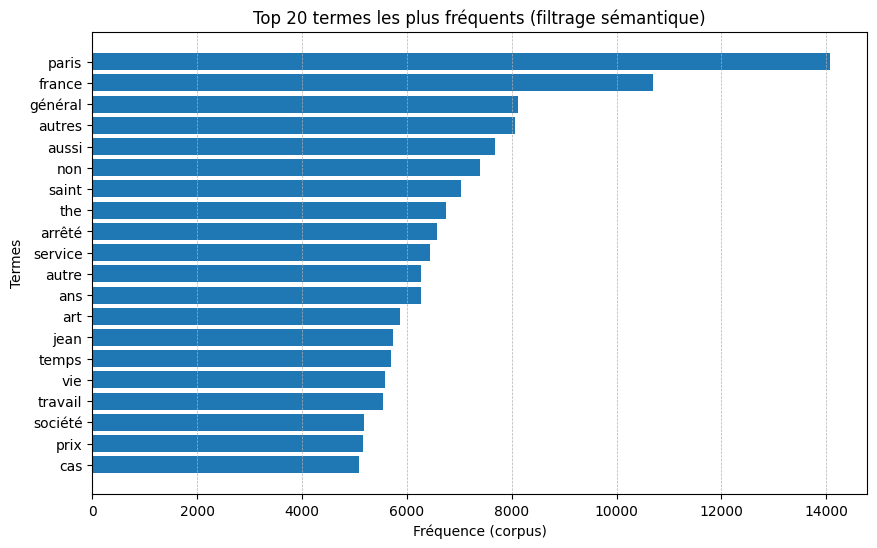

terme  frequence
0     paris      14075
1    france      10703
2   général       8116
3    autres       8067
4     aussi       7684
5       non       7403
6     saint       7041
7       the       6743
8    arrêté       6585
9   service       6446
10    autre       6277
11      ans       6272
12      art       5879
13     jean       5731
14    temps       5691
15      vie       5583
16  travail       5537
17  société       5193
18     prix       5169
19      cas       5088

In [ ]:
# 13bis) Analyse linguistique : termes les plus fréquents (version "plus sémantique")
# Objectif : barplot dei termini frequenti, evitando parole troppo generiche.

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# --- 1) Recupero dataframe ---
if "df_filtre" in globals():
    _df = df_filtre
elif "df" in globals():
    _df = df
else:
    raise NameError("Aucun dataframe trouvé : ni 'df_filtre' ni 'df'.")

# --- 2) Recupero colonna testo pulito ---
text_col = None
for c in ["texte_nettoye", "texte_nettoyé", "clean_text", "text_clean"]:
    if c in _df.columns:
        text_col = c
        break
if text_col is None:
    raise KeyError(f"Colonne texte nettoyé introuvable. Colonnes dispo: {list(_df.columns)}")

# --- 3) Tokenizzazione + filtri anti-rumore e anti-parole generiche ---
texts = _df[text_col].fillna("").astype(str).tolist()
tokens = " ".join(texts).split()

# (a) elimina token troppo corti (rumore OCR / residui)
tokens = [t for t in tokens if len(t) >= 3]

# (b) lista breve di parole molto generiche (da escludere per rendere il grafico più informativo)
stop_semantici = {
    "plus","cette","être","comme","deux","fait","dont","tout","bien","peut","sans","rue","après","très",
    "sous","entre","tous","cette","cet","cette","celles","ceux","cela","ceci",
    "ainsi","alors","encore","donc","toute","toutes","toutefois","toujours",
    "leur","leurs","lors","lorsque","avait","avoir","sont","été","faire","faut",
    "elle","elles","ils","nous","vous","mais","avec","pour","dans","sur","par",
    "moins","même","trop","chez","tout","tous","toute","toutes"
}

tokens = [t for t in tokens if t not in stop_semantici]

freqs = Counter(tokens)

# --- 4) Top N e grafico ---
TOP_N = 20
top = freqs.most_common(TOP_N)
top_df = pd.DataFrame(top, columns=["terme", "frequence"]).sort_values("frequence", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_df["terme"], top_df["frequence"])
plt.xlabel("Fréquence (corpus)")
plt.ylabel("Termes")
plt.title(f"Top {TOP_N} termes les plus fréquents (filtrage sémantique)")
plt.grid(True, axis="x", linestyle="--", linewidth=0.5)
plt.show()

# stampa tabella in ordine decrescente (comoda per slide)
top_df.sort_values("frequence", ascending=False).reset_index(drop=True)


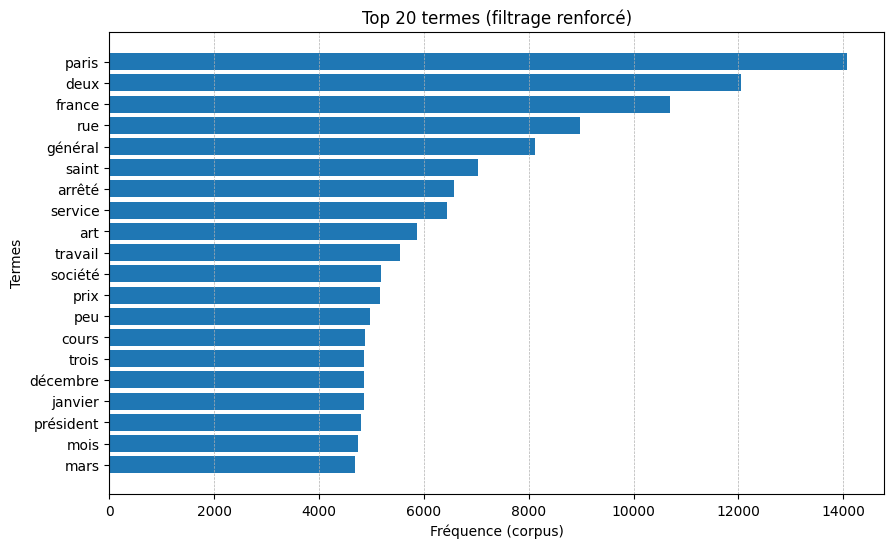

terme  frequence
0       paris      14075
1        deux      12053
2      france      10703
3         rue       8971
4     général       8116
5       saint       7041
6      arrêté       6585
7     service       6446
8         art       5879
9     travail       5537
10    société       5193
11       prix       5169
12        peu       4966
13      cours       4888
14      trois       4855
15   décembre       4855
16    janvier       4853
17  président       4803
18       mois       4743
19       mars       4688

In [ ]:
# 13ter) Top termes fréquents (filtrage renforcé : OCR/anglais + génériques)
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re

# --- dataframe ---
if "df_filtre" in globals():
    _df = df_filtre
elif "df" in globals():
    _df = df
else:
    raise NameError("Aucun dataframe trouvé : ni 'df_filtre' ni 'df'.")

# --- colonne texte nettoyé ---
text_col = None
for c in ["texte_nettoye", "texte_nettoyé", "clean_text", "text_clean"]:
    if c in _df.columns:
        text_col = c
        break
if text_col is None:
    raise KeyError(f"Colonne texte nettoyé introuvable. Colonnes dispo: {list(_df.columns)}")

texts = _df[text_col].fillna("").astype(str).tolist()
tokens = " ".join(texts).split()

# (1) garde solo token alfabetici (niente numeri/simboli OCR)
tokens = [t for t in tokens if re.fullmatch(r"[a-zàâçéèêëîïôùûüÿñæœ]+", t)]

# (2) elimina token corti
tokens = [t for t in tokens if len(t) >= 3]

# (3) stop “semantici” più aggressivi (aggiungo i tuoi output)
stop_semantici_plus = {
    "plus","cette","être","comme","fait","dont","tout","bien","peut","sans","après","très","sous","entre","tous",
    "ainsi","alors","encore","donc","toute","toutes","toutefois","toujours","leur","leurs","lors","lorsque",
    "avait","avoir","sont","été","faire","faut","elle","elles","ils","nous","vous","mais","avec","pour","dans","sur","par",
    "moins","même","trop","chez",
    # aggiunte:
    "autres","autre","aussi","non","cas","ans","temps","vie",
    # rumore inglese:
    "the","and","that","for","with","from"
}

tokens = [t for t in tokens if t not in stop_semantici_plus]

# (4) opzionale: togli nomi propri frequenti (se vuoi)
stop_nomi = {"jean"}  # puoi aggiungere "saint" se disturba
tokens = [t for t in tokens if t not in stop_nomi]

freqs = Counter(tokens)

TOP_N = 20
top = freqs.most_common(TOP_N)
top_df = pd.DataFrame(top, columns=["terme", "frequence"]).sort_values("frequence", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_df["terme"], top_df["frequence"])
plt.xlabel("Fréquence (corpus)")
plt.ylabel("Termes")
plt.title(f"Top {TOP_N} termes (filtrage renforcé)")
plt.grid(True, axis="x", linestyle="--", linewidth=0.5)
plt.show()

top_df.sort_values("frequence", ascending=False).reset_index(drop=True)


Dataframe utilisé : df_filtre | Taille : (292, 11)
Colonne topic : topic_dominant


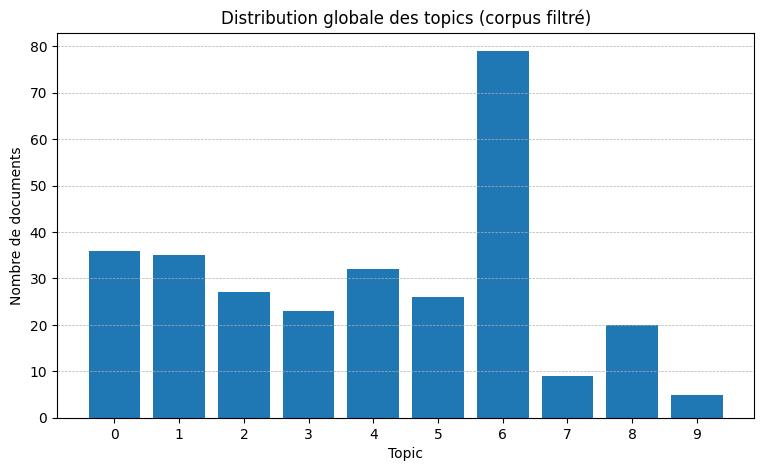

topic  count
0      0     36
1      1     35
2      2     27
3      3     23
4      4     32
5      5     26
6      6     79
7      7      9
8      8     20
9      9      5

In [ ]:
# 14) Synthèse thématique : distribution globale des topics (barplot)
# Objectif : visualiser combien de documents appartiennent à chaque topic (sur tout le corpus filtré).

import matplotlib.pyplot as plt
import pandas as pd

# --- 1) Choix du dataframe ---
if "df_filtre" in globals():
    _df = df_filtre.copy()
    df_name = "df_filtre"
elif "df" in globals():
    _df = df.copy()
    df_name = "df"
else:
    raise NameError("Aucun dataframe trouvé : ni 'df_filtre' ni 'df'.")

# --- 2) Détection de la colonne topic ---
possible_topic_cols = ["topic_dominant", "topic", "dominant_topic"]
topic_col = next((c for c in possible_topic_cols if c in _df.columns), None)

if topic_col is None:
    raise KeyError(
        "Colonne de topic introuvable. Colonnes disponibles :\n"
        + ", ".join(_df.columns)
        + "\nAttendu : 'topic_dominant' (ou 'topic')."
    )

print("Dataframe utilisé :", df_name, "| Taille :", _df.shape)
print("Colonne topic :", topic_col)

# --- 3) Comptage + tri ---
topic_counts = _df[topic_col].value_counts().sort_index()

# --- 4) Barplot ---
plt.figure(figsize=(9, 5))
plt.bar(topic_counts.index.astype(str), topic_counts.values)
plt.xlabel("Topic")
plt.ylabel("Nombre de documents")
plt.title("Distribution globale des topics (corpus filtré)")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.show()

# --- 5) Tableau récapitulatif ---
display(pd.DataFrame({"topic": topic_counts.index, "count": topic_counts.values}))


Topics sélectionnés pour la visualisation : [6, 0, 1, 4, 2]


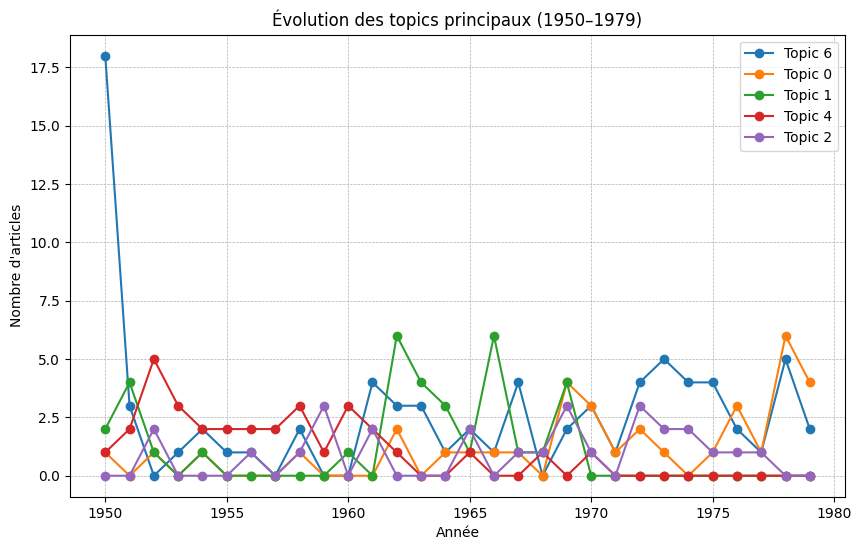

topic_dominant   6  0  1  4  2
annee                         
1950            18  1  2  1  0
1951             3  0  4  2  0
1952             0  1  1  5  2
1953             1  0  0  3  0
1954             2  1  1  2  0
1955             1  0  0  2  0
1956             1  0  0  2  1
1957             0  0  0  2  0
1958             2  1  0  3  1
1959             0  0  0  1  3
1960             0  0  1  3  0
1961             4  0  0  2  2
1962             3  2  6  1  0
1963             3  0  4  0  0
1964             1  1  3  0  0
1965             2  1  1  1  2
1966             1  1  6  0  0
1967             4  1  1  0  1
1968             0  0  1  1  1
1969             2  4  4  0  3
1970             3  3  0  1  1
1971             1  1  0  0  0
1972             4  2  0  0  3
1973             5  1  0  0  2
1974             4  0  0  0  2
1975             4  1  0  0  1
1976             2  3  0  0  1
1977             1  1  0  0  1
1978             5  6  0  0  0
1979             2  4  0  0  0

In [ ]:
# 15) Évolution des topics dans le temps (1950–1979)
# Objectif : tracer une courbe montrant comment les topics évoluent année par année.

import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Choix du dataframe ---
if "df_filtre" in globals():
    _df = df_filtre.copy()
    df_name = "df_filtre"
elif "df" in globals():
    _df = df.copy()
    df_name = "df"
else:
    raise NameError("Aucun dataframe trouvé : ni 'df_filtre' ni 'df'.")

# Vérification colonnes essentielles
required_cols = ["annee", topic_col]
for col in required_cols:
    if col not in _df.columns:
        raise KeyError(f"Colonne obligatoire manquante : {col}")

# Nettoyage année
_df = _df.dropna(subset=["annee"])
_df["annee"] = _df["annee"].astype(int)

# --- 2) Tableau croisé année × topic ---
pivot = _df.pivot_table(
    index="annee",
    columns=topic_col,
    values="complete_text",  # n'importe quelle colonne non nulle
    aggfunc="count",
    fill_value=0
)

# --- 3) Sélection des 5 topics dominants globalement ---
top_topics = topic_counts.sort_values(ascending=False).head(5).index.tolist()
pivot_top = pivot[top_topics]

print("Topics sélectionnés pour la visualisation :", top_topics)

# --- 4) Line plot ---
plt.figure(figsize=(10, 6))
for t in top_topics:
    plt.plot(pivot_top.index, pivot_top[t], marker="o", label=f"Topic {t}")

plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.title("Évolution des topics principaux (1950–1979)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

# --- 5) Affichage tableau ---
pivot_top


Nœuds : 200
Arêtes : 19900


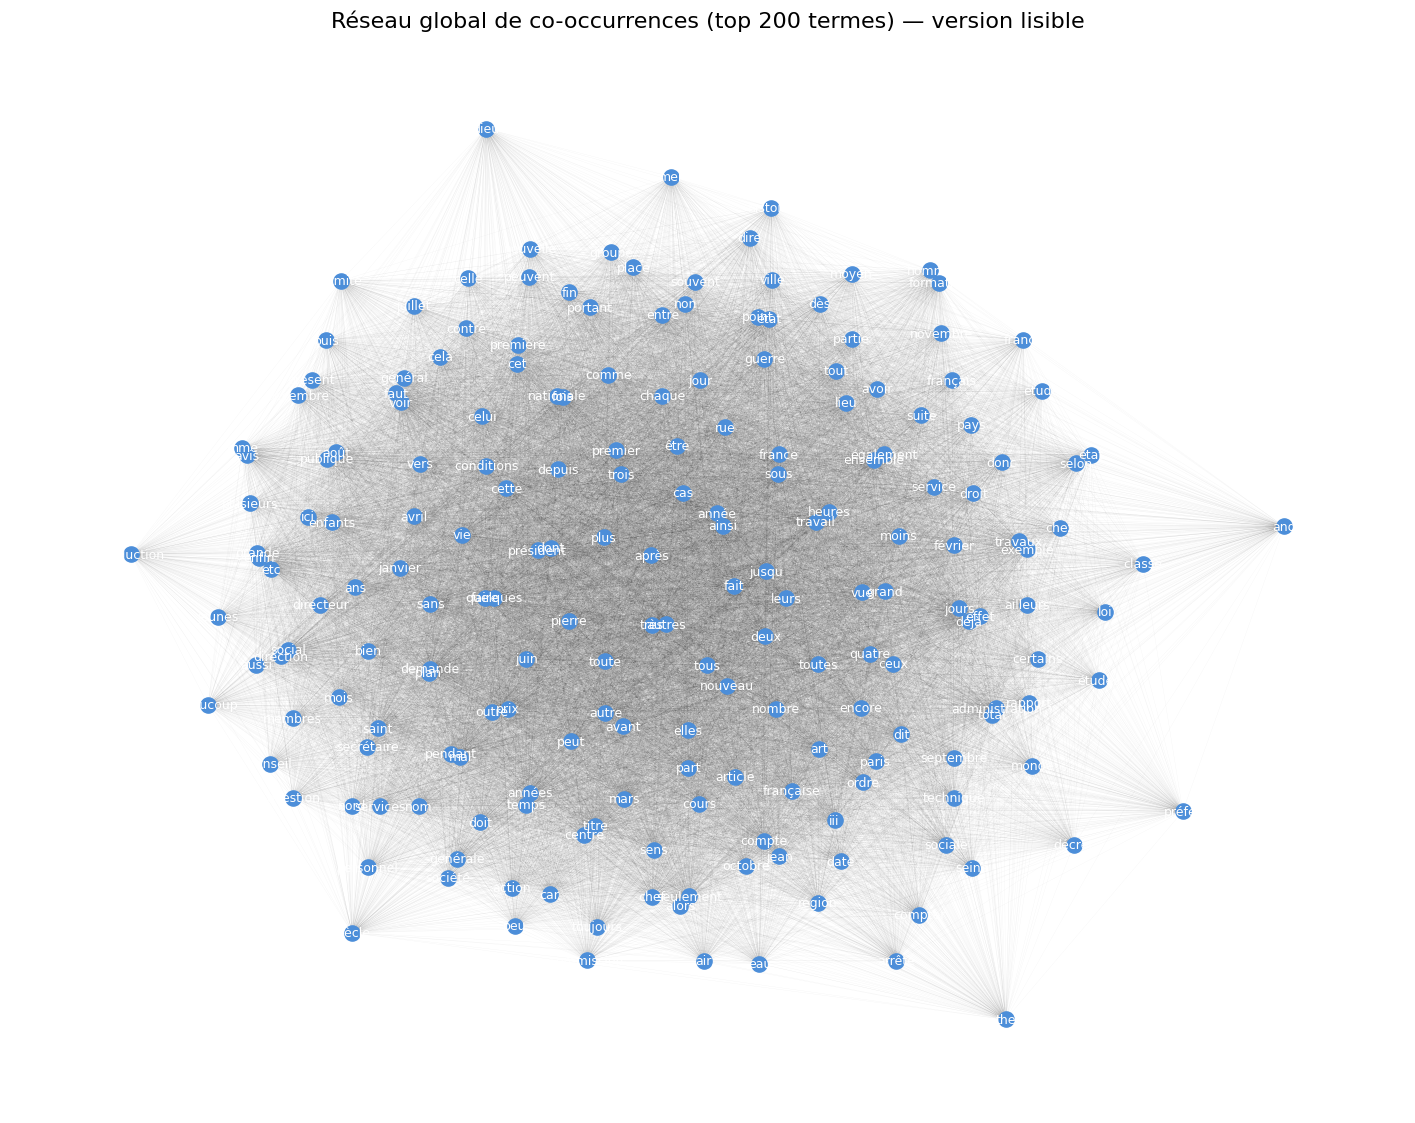

In [ ]:
# 16) Réseau global de co-occurrences (top 200 termes) - Version lisible mais identique

import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

# --- 1) Vérification dataframe ---
if "df_filtre" in globals():
    _df = df_filtre.copy()
elif "df" in globals():
    _df = df.copy()
else:
    raise NameError("Aucun dataframe trouvé : ni 'df_filtre' ni 'df'.")

# --- 2) Colonne texte nettoyé ---
possible_cols = ["texte_nettoye", "texte_nettoyé"]
text_col = next((c for c in possible_cols if c in _df.columns), None)

if text_col is None:
    raise KeyError("Impossible de trouver la colonne texte nettoyé.")

texts = _df[text_col].fillna("").astype(str).tolist()

# --- 3) Top 200 mots ---
all_tokens = " ".join(texts).split()
freqs = Counter(all_tokens)
top_terms = set([w for w, _ in freqs.most_common(200)])

# --- 4) Co-occurrences ---
cooc = Counter()
for txt in texts:
    tokens = [t for t in txt.split() if t in top_terms]
    unique_tokens = sorted(set(tokens))
    for w1, w2 in combinations(unique_tokens, 2):
        cooc[(w1, w2)] += 1

# --- 5) Graph complet, identique à ton original ---
G = nx.Graph()
G.add_nodes_from(top_terms)

for (w1, w2), v in cooc.items():
    G.add_edge(w1, w2, weight=v)

print("Nœuds :", len(G.nodes()))
print("Arêtes :", len(G.edges()))

# --- 6) Amélioration VISUELLE uniquement ---
plt.figure(figsize=(18, 14))

pos = nx.spring_layout(
    G,
    k=0.55,            # espacement légèrement augmenté (meilleure lisibilité)
    iterations=70,
    seed=42
)

# Arêtes très transparentes
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.05)

# Nœuds : bleu clair, plus grands
nx.draw_networkx_nodes(G, pos, node_size=120, node_color="#4C8ED9")

# Labels lisibles : blanc, taille plus grande
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_color="white"
)

plt.title("Réseau global de co-occurrences (top 200 termes) — version lisible", fontsize=16)
plt.axis("off")
plt.show()


Poids min / médiane / max : 41 224.0 290
Soglia scelta (quantile 0.9) -> weight >= 262
Après filtrage :
Nœuds : 86
Arêtes : 2068
Nombre de communautés détectées : 2
Tailles des communautés (top 10) : [44, 42]
Modularité (greedy) : 0.0947


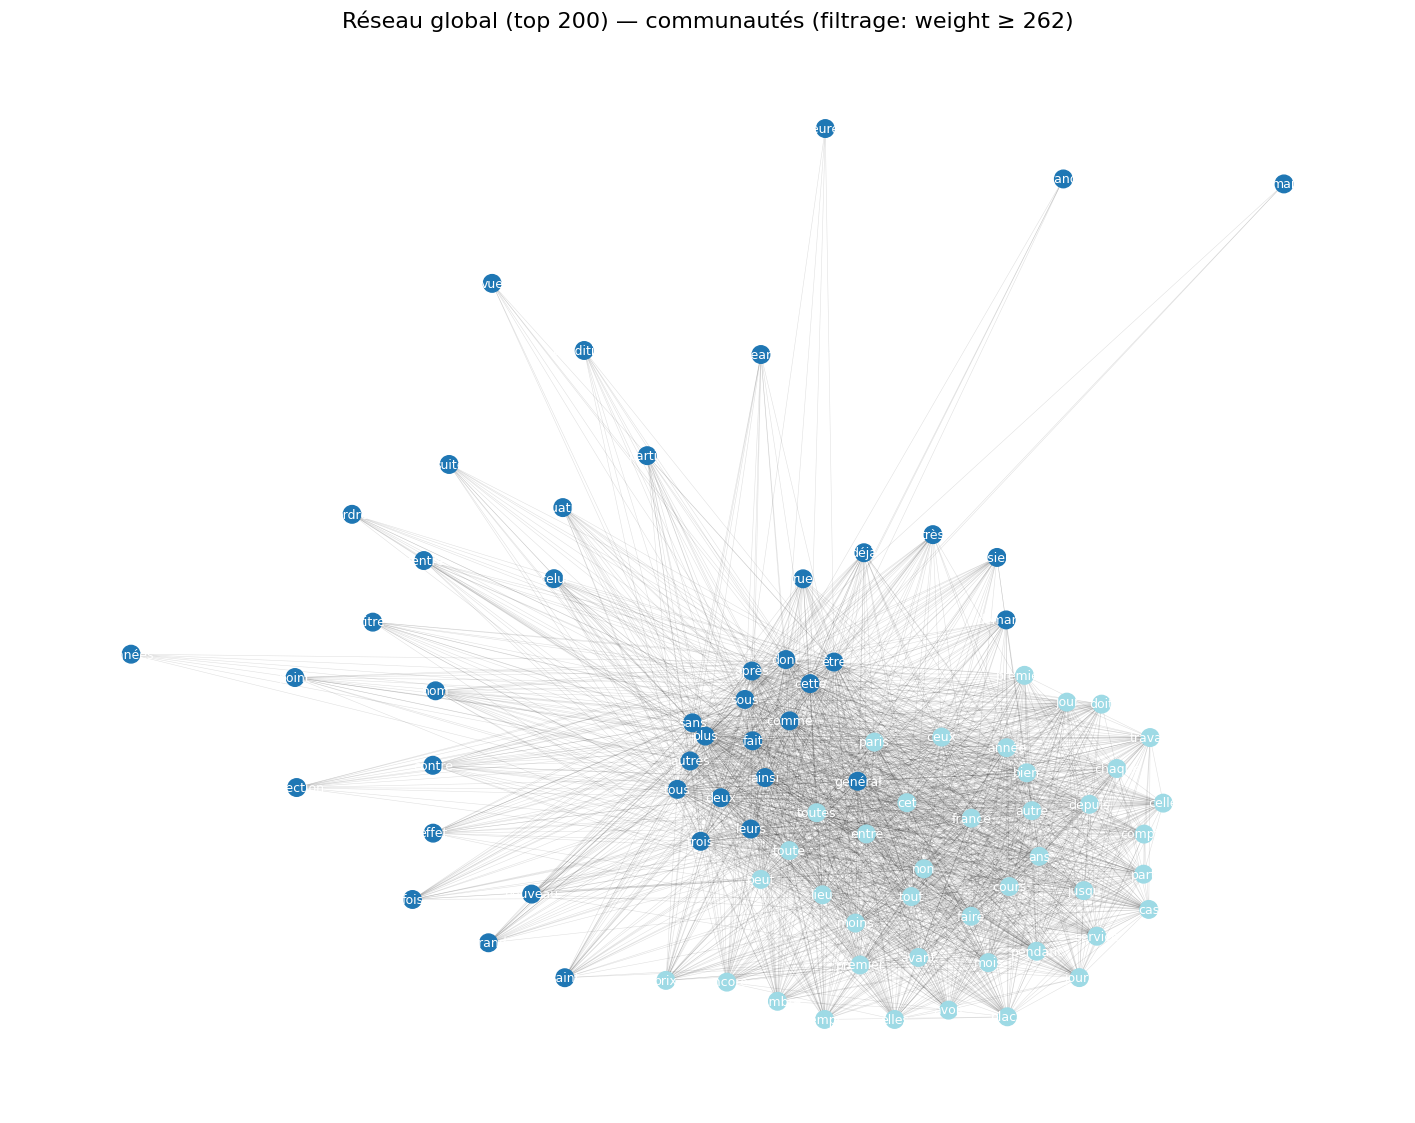


Communauté 1 (taille=44) — exemple de termes :
ainsi, années, après, autres, celui, centre, cette, comme, conditions, contre, demande, deux, direction, dont, déjà, effet, fait, fois, grand, grande, général, heures, jean, leurs, mai, nom, nouveau, ordre, partie, plus

Communauté 2 (taille=42) — exemple de termes :
année, ans, autre, avant, avoir, bien, cas, celle, cet, ceux, chaque, compte, cours, depuis, doit, elles, encore, entre, faire, france, jour, jours, jusqu, lieu, moins, mois, nombre, non, paris, part


In [ ]:
# 17) Réseau global : détection de communautés (version utile)
# Objectif : obtenir des communautés réelles en filtrant les arêtes faibles (poids faible).

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

if "G" not in globals():
    raise NameError("Le graphe 'G' n'existe pas. Exécute d'abord la cellule 16.")

# --- 1) Choix d’un sous-graphe plus informatif : filtrage par poids ---
# On récupère tous les poids d’arêtes
weights = np.array([d.get("weight", 1) for _, _, d in G.edges(data=True)])
print("Poids min / médiane / max :", weights.min(), np.median(weights), weights.max())

# On choisit une soglia automatica: quantile alto (es. 90° percentile)
# (tiene solo gli archi più "forti" e fa emergere cluster)
q = 0.90
thr = int(np.quantile(weights, q))
thr = max(thr, 2)  # sicurezza
print(f"Soglia scelta (quantile {q}) -> weight >= {thr}")

# Costruisci sub-grafo con archi forti
edges_strong = [(u, v, d) for u, v, d in G.edges(data=True) if d.get("weight", 1) >= thr]
Gf = nx.Graph()
Gf.add_nodes_from(G.nodes())
Gf.add_edges_from([(u, v, d) for u, v, d in edges_strong])

# Rimuovi nodi isolati per la visualizzazione (opzionale ma consigliato)
isolates = list(nx.isolates(Gf))
Gf.remove_nodes_from(isolates)

print("Après filtrage :")
print("Nœuds :", Gf.number_of_nodes())
print("Arêtes :", Gf.number_of_edges())

# Se è ancora troppo denso o troppo sparso, puoi ritoccare q (0.85 / 0.92 / 0.95)

# --- 2) Détection de communautés sur le graphe filtré ---
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

communities = list(greedy_modularity_communities(Gf))
print("Nombre de communautés détectées :", len(communities))
print("Tailles des communautés (top 10) :", sorted([len(c) for c in communities], reverse=True)[:10])

mod = modularity(Gf, communities) if Gf.number_of_edges() > 0 and len(communities) > 1 else 0.0
print("Modularité (greedy) :", round(mod, 4))

node_to_comm = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_comm[node] = i

# --- 3) Visualisation : même style, mais lisible + clusters ---
plt.figure(figsize=(18, 14))

pos = nx.spring_layout(Gf, k=0.55, iterations=80, seed=42)

nx.draw_networkx_edges(Gf, pos, width=0.4, alpha=0.12)

comm_ids = [node_to_comm[n] for n in Gf.nodes()]
nx.draw_networkx_nodes(
    Gf, pos,
    node_size=160,
    node_color=comm_ids,
    cmap=plt.cm.tab20
)

nx.draw_networkx_labels(Gf, pos, font_size=9, font_color="white")

plt.title(f"Réseau global (top 200) — communautés (filtrage: weight ≥ {thr})", fontsize=16)
plt.axis("off")
plt.show()

# --- 4) Esempi di termini per le 3 comunità più grandi ---
biggest = sorted(communities, key=len, reverse=True)[:3]
for i, comm in enumerate(biggest, start=1):
    sample_terms = sorted(list(comm))[:30]
    print(f"\nCommunauté {i} (taille={len(comm)}) — exemple de termes :")
    print(", ".join(sample_terms))


Dataframe utilisé : df_filtre | Taille : (292, 11)
Colonne texte : texte_nettoye | Colonne décennie : decennie

--- Décennie : 1950s ---
Documents : 97
Vocabulaire total (types) : 33449
Top termes conservés : 200
Nœuds : 200
Arêtes : 7264


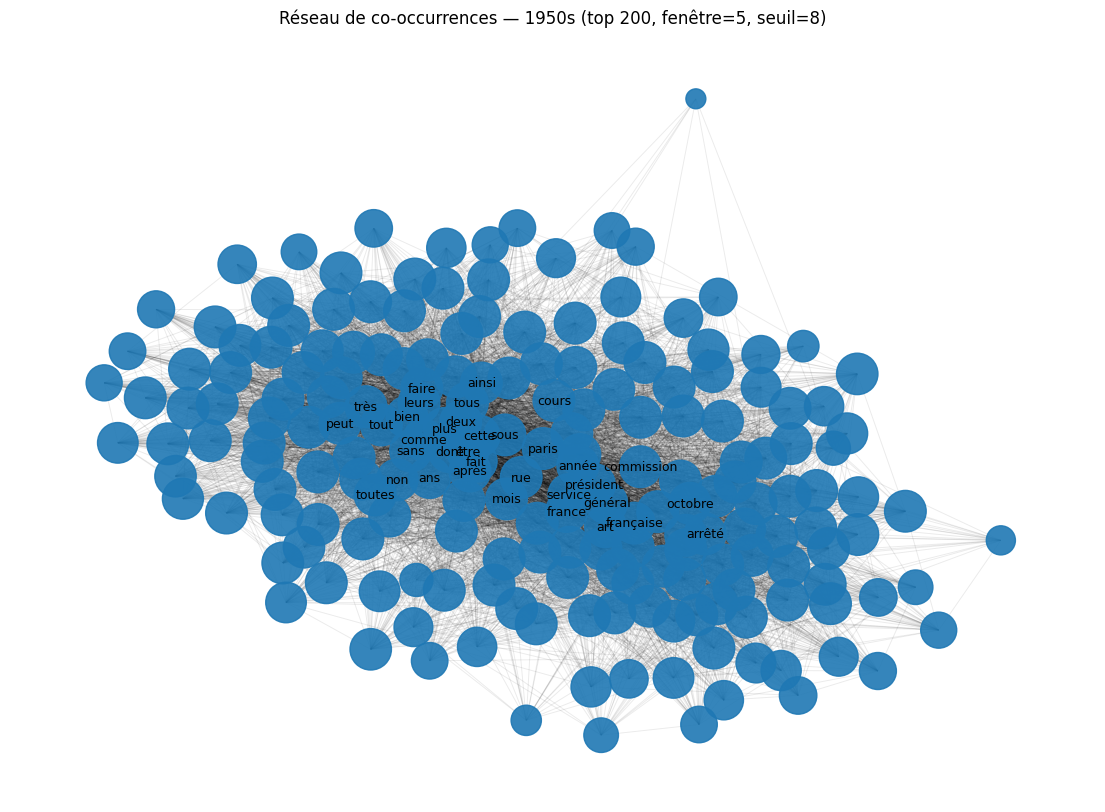


--- Décennie : 1960s ---
Documents : 100
Vocabulaire total (types) : 31793
Top termes conservés : 200
Nœuds : 200
Arêtes : 6961


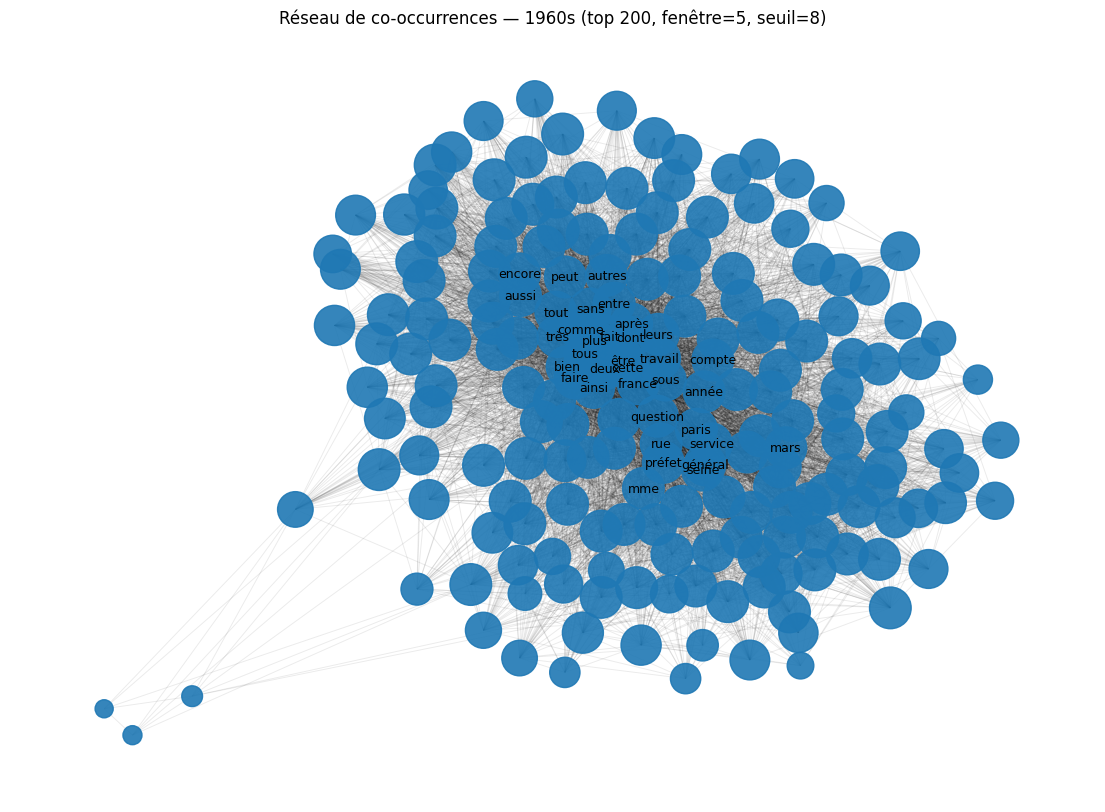


--- Décennie : 1970s ---
Documents : 95
Vocabulaire total (types) : 32487
Top termes conservés : 200
Nœuds : 200
Arêtes : 6267


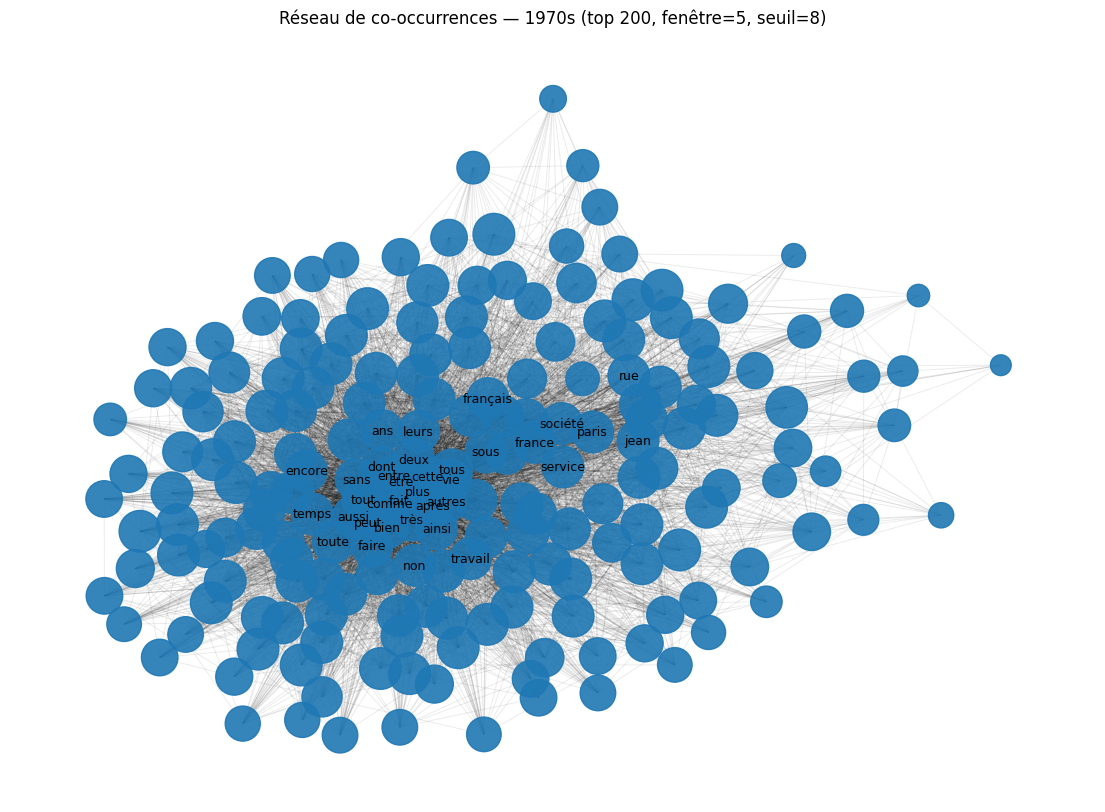

docs  nodes  edges   density  avg_degree  avg_clustering  \
decennie                                                             
1950s       97    200   7264  0.365025       72.64        0.637636   
1960s      100    200   6961  0.349799       69.61        0.649538   
1970s       95    200   6267  0.314925       62.67        0.646732   

                                           top_degree_terms  
decennie                                                     
1950s     cette(186), plus(178), france(175), être(172),...  
1960s     cette(191), paris(188), plus(185), être(177), ...  
1970s     cette(190), plus(189), être(179), comme(167), ...

In [ ]:
# 18) Réseaux de co-occurrences par décennie + métriques (version essentielle)
# Objectif : construire un graphe par décennie (1950s/1960s/1970s),
# afficher 3 visualisations lisibles et comparer des métriques simples.

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from itertools import combinations


# 0) Récupération du dataframe
# -----------------------------
if "df_filtre" in globals():
    _df = df_filtre.copy()
    df_name = "df_filtre"
elif "df" in globals():
    _df = df.copy()
    df_name = "df"
else:
    raise NameError("Aucun dataframe trouvé : ni 'df_filtre' ni 'df'. Relance la cellule de chargement/filtrage.")

# -----------------------------
# 1) Colonnes attendues
# -----------------------------
# colonne texte nettoyé
possible_text_cols = ["texte_nettoye", "texte_nettoyé", "clean_text", "text_clean"]
text_col = next((c for c in possible_text_cols if c in _df.columns), None)
if text_col is None:
    raise KeyError("Colonne de texte nettoyé introuvable. Attendu : 'texte_nettoye' (ou 'texte_nettoyé').")

# colonne décennie
possible_dec_cols = ["decennie", "decennie_norm", "decade", "decennie_str"]
dec_col = next((c for c in possible_dec_cols if c in _df.columns), None)
if dec_col is None:
    raise KeyError("Colonne de décennie introuvable. Attendu : 'decennie' (1950s/1960s/1970s).")

print("Dataframe utilisé :", df_name, "| Taille :", _df.shape)
print("Colonne texte :", text_col, "| Colonne décennie :", dec_col)

# -----------------------------
# 2) Paramètres (essentiels)
# -----------------------------
TOP_N_TERMS = 200          # vocabulaire maximal par décennie (réduis à 120 si c'est lent)
WINDOW = 5                # fenêtre de co-occurrence (mots)
MIN_EDGE_WEIGHT = 8       # seuil pour alléger le graphe (augmente si trop dense)
MAX_TOKENS_PER_DOC = 2000 # coupe sécurité pour les articles très longs (évite explosion combinatoire)

# -----------------------------
# 3) Fonctions utilitaires
# -----------------------------
def tokenize_basic(text: str):
    # texte déjà nettoyé -> split simple
    tokens = str(text).split()
    # filtre tokens trop courts / bruit
    tokens = [t for t in tokens if len(t) >= 3]
    return tokens

def build_cooc_graph(texts, top_terms_set, window=5, min_edge_weight=5):
    edge_counts = Counter()

    for txt in texts:
        toks = tokenize_basic(txt)
        if not toks:
            continue
        # limiter longueur doc pour ne pas exploser
        toks = toks[:MAX_TOKENS_PER_DOC]
        # garder uniquement top vocab
        toks = [t for t in toks if t in top_terms_set]
        if len(toks) < 2:
            continue

        # co-occurrence dans une fenêtre glissante
        for i in range(len(toks)):
            w = toks[i]
            jmax = min(i + window, len(toks))
            for j in range(i + 1, jmax):
                u = toks[j]
                if u == w:
                    continue
                a, b = (w, u) if w < u else (u, w)
                edge_counts[(a, b)] += 1

    # construire graphe
    G = nx.Graph()
    for (a, b), w in edge_counts.items():
        if w >= min_edge_weight:
            G.add_edge(a, b, weight=w)

    return G

def graph_metrics(G: nx.Graph):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    dens = nx.density(G) if n > 1 else 0.0

    if n > 0:
        degrees = [d for _, d in G.degree()]
        avg_degree = float(np.mean(degrees)) if degrees else 0.0
    else:
        avg_degree = 0.0

    # clustering (peut être lent si graphe très dense)
    try:
        avg_clust = nx.average_clustering(G, weight=None) if n > 2 else 0.0
    except Exception:
        avg_clust = np.nan

    # top centralité (degree)
    top_deg = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]
    top_deg_terms = ", ".join([f"{t}({d})" for t, d in top_deg])

    return {
        "nodes": n,
        "edges": m,
        "density": dens,
        "avg_degree": avg_degree,
        "avg_clustering": avg_clust,
        "top_degree_terms": top_deg_terms
    }

def draw_graph_readable(G, title):
    plt.figure(figsize=(14, 10))
    if G.number_of_nodes() == 0:
        plt.title(title + " — graphe vide (seuil trop strict)")
        plt.axis("off")
        plt.show()
        return

    # layout
    pos = nx.spring_layout(G, seed=42, k=0.35)

    # taille noeuds selon degré (caps pour lisibilité)
    deg = dict(G.degree())
    sizes = [min(900, 80 + 18 * deg[n]) for n in G.nodes()]

    # arêtes : très claires
    nx.draw_networkx_edges(G, pos, alpha=0.08, width=0.7)

    # noeuds
    nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.9)

    # labels : ne pas étiqueter tout (sinon illisible)
    # on étiquette seulement les 35 mots les plus centraux
    top_labels = [t for t, _ in sorted(G.degree, key=lambda x: x[1], reverse=True)[:35]]
    labels = {t: t for t in top_labels}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    plt.title(title)
    plt.axis("off")
    plt.show()

# -----------------------------
# 4) Boucle par décennie
# -----------------------------
decades_order = ["1950s", "1960s", "1970s"]
decades_present = [d for d in decades_order if d in set(_df[dec_col].astype(str))]

if not decades_present:
    # fallback : prendre les 3 plus fréquentes
    decades_present = _df[dec_col].astype(str).value_counts().head(3).index.tolist()

results = []
graphs = {}

for dec in decades_present:
    sub = _df[_df[dec_col].astype(str) == dec].copy()
    texts = sub[text_col].fillna("").astype(str).tolist()

    # top vocab par fréquence
    tokens = []
    for t in texts:
        toks = tokenize_basic(t)
        toks = toks[:MAX_TOKENS_PER_DOC]
        tokens.extend(toks)

    freq = Counter(tokens)
    top_terms = [w for w, _ in freq.most_common(TOP_N_TERMS)]
    top_set = set(top_terms)

    print(f"\n--- Décennie : {dec} ---")
    print("Documents :", len(sub))
    print("Vocabulaire total (types) :", len(freq))
    print("Top termes conservés :", len(top_terms))

    # graphe
    G = build_cooc_graph(texts, top_set, window=WINDOW, min_edge_weight=MIN_EDGE_WEIGHT)
    graphs[dec] = G

    print("Nœuds :", G.number_of_nodes())
    print("Arêtes :", G.number_of_edges())

    # métriques
    met = graph_metrics(G)
    met["decennie"] = dec
    met["docs"] = len(sub)
    met["top_terms_used"] = len(top_terms)
    results.append(met)

    # visualisation lisible
    draw_graph_readable(G, f"Réseau de co-occurrences — {dec} (top {TOP_N_TERMS}, fenêtre={WINDOW}, seuil={MIN_EDGE_WEIGHT})")

# -----------------------------
# 5) Tableau comparatif des métriques
# -----------------------------
metrics_df = pd.DataFrame(results).set_index("decennie").sort_index()
display(metrics_df[["docs","nodes","edges","density","avg_degree","avg_clustering","top_degree_terms"]])



--- 1950s ---
Nombre de communautés : 2
Tailles (top 10) : [118, 82]
Modularité : 0.18846376504600645


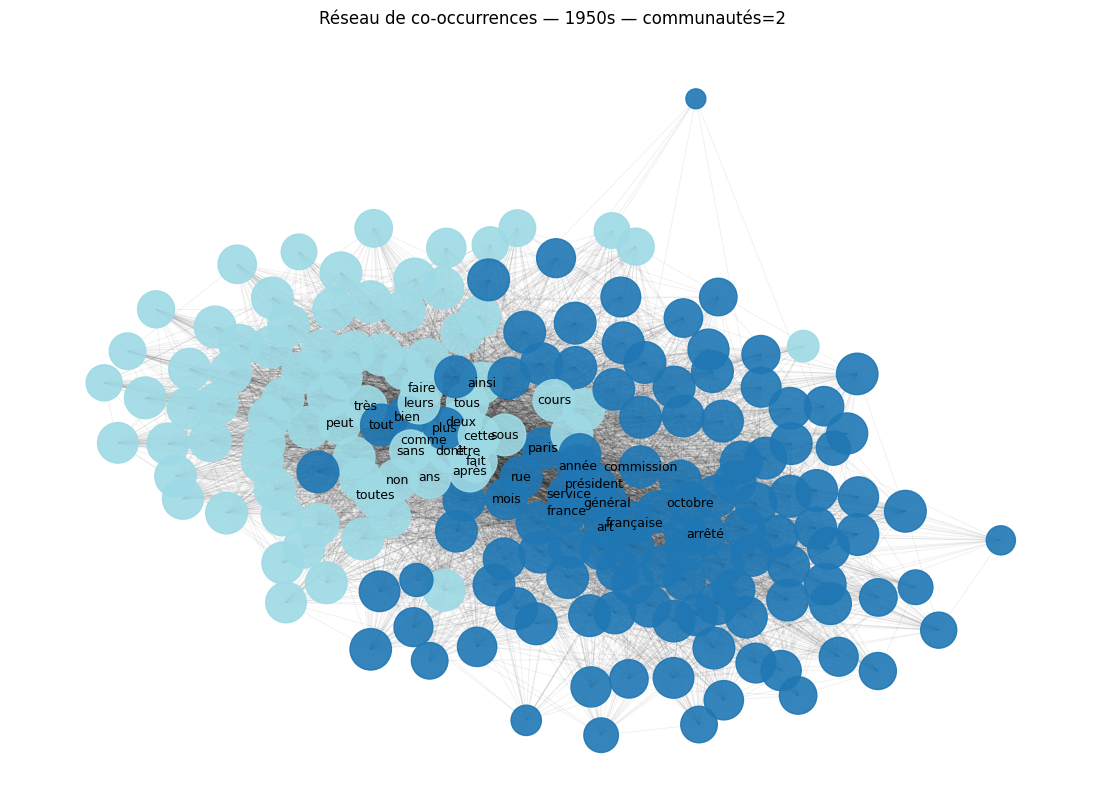


--- 1960s ---
Nombre de communautés : 2
Tailles (top 10) : [101, 99]
Modularité : 0.18797832238655035


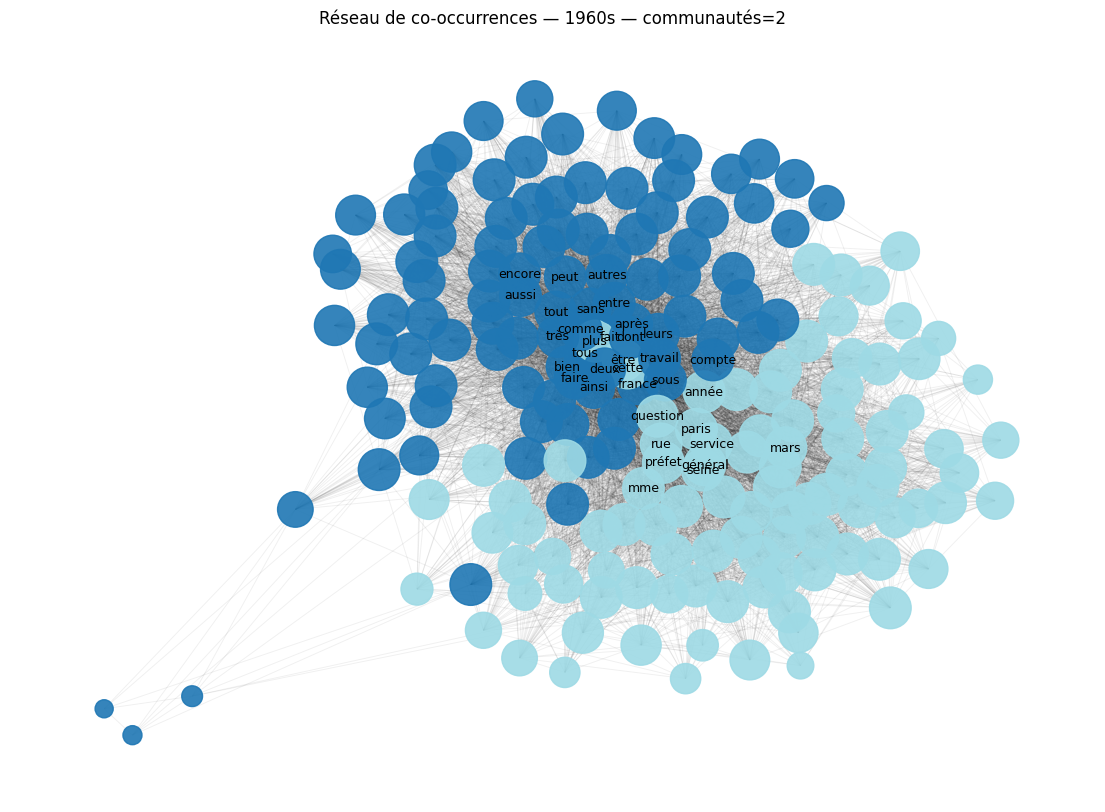


--- 1970s ---
Nombre de communautés : 3
Tailles (top 10) : [103, 77, 20]
Modularité : 0.15664012201549232


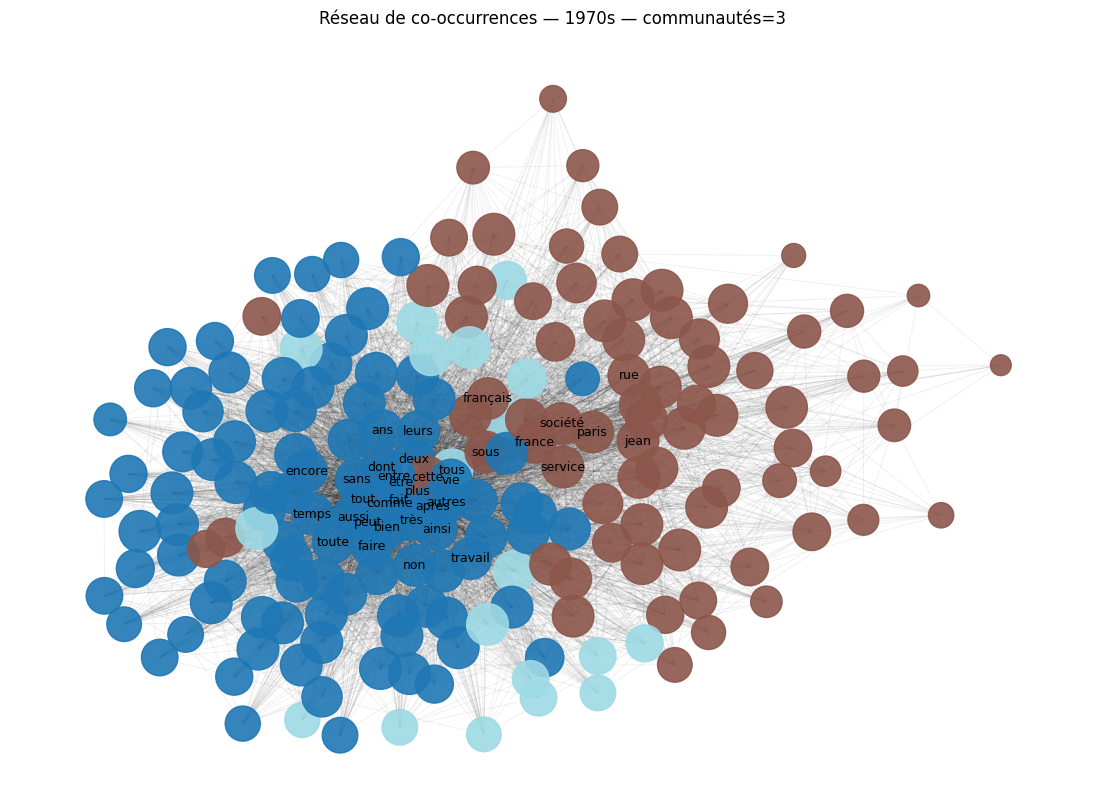

nodes  edges  n_communities  modularity top_community_sizes
decennie                                                             
1950s       200   7264              2    0.188464           [118, 82]
1960s       200   6961              2    0.187978           [101, 99]
1970s       200   6267              3    0.156640       [103, 77, 20]

In [ ]:
# 19) Communautés par décennie (community detection) + modularité + visualisations
# Objectif : détecter des communautés dans chaque graphe décennal, afficher modularité et tailles.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, modularity

if "graphs" not in globals() or not isinstance(graphs, dict) or len(graphs) == 0:
    raise NameError("Variable 'graphs' introuvable. Exécute d'abord la cellule 18 (réseaux par décennie).")

def draw_graph_communities(G, title, max_labels=35):
    plt.figure(figsize=(14, 10))
    if G.number_of_nodes() == 0:
        plt.title(title + " — graphe vide")
        plt.axis("off")
        plt.show()
        return

    # Layout stable
    pos = nx.spring_layout(G, seed=42, k=0.35)

    # Communautés (greedy modularity)
    comms = list(greedy_modularity_communities(G))
    comms_sorted = sorted(comms, key=len, reverse=True)

    # Index communauté par noeud
    node_to_comm = {}
    for i, comm in enumerate(comms_sorted):
        for n in comm:
            node_to_comm[n] = i

    node_colors = [node_to_comm[n] for n in G.nodes()]

    # tailles noeuds (degré)
    deg = dict(G.degree())
    sizes = [min(900, 80 + 18 * deg[n]) for n in G.nodes()]

    # Arêtes très claires
    nx.draw_networkx_edges(G, pos, alpha=0.06, width=0.7)

    # Nœuds colorés par communauté (palette par défaut)
    nx.draw_networkx_nodes(
        G, pos,
        node_size=sizes,
        node_color=node_colors,
        cmap=plt.cm.tab20,
        alpha=0.9
    )

    # Labels : seulement les plus centraux
    top_labels = [t for t, _ in sorted(G.degree, key=lambda x: x[1], reverse=True)[:max_labels]]
    labels = {t: t for t in top_labels}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    plt.title(title + f" — communautés={len(comms_sorted)}")
    plt.axis("off")
    plt.show()

    return comms_sorted

rows = []

for dec, G in graphs.items():
    print(f"\n--- {dec} ---")
    if G.number_of_nodes() < 5 or G.number_of_edges() == 0:
        print("Graphe trop petit pour une détection robuste.")
        rows.append({
            "decennie": dec,
            "nodes": G.number_of_nodes(),
            "edges": G.number_of_edges(),
            "n_communities": np.nan,
            "modularity": np.nan,
            "top_community_sizes": ""
        })
        continue

    comms = list(greedy_modularity_communities(G))
    comms_sorted = sorted(comms, key=len, reverse=True)

    try:
        Q = modularity(G, comms_sorted)
    except Exception:
        Q = np.nan

    sizes = [len(c) for c in comms_sorted]
    top_sizes = sizes[:10]

    print("Nombre de communautés :", len(comms_sorted))
    print("Tailles (top 10) :", top_sizes)
    print("Modularité :", Q)

    # Figure
    draw_graph_communities(G, f"Réseau de co-occurrences — {dec}")

    rows.append({
        "decennie": dec,
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "n_communities": len(comms_sorted),
        "modularity": Q,
        "top_community_sizes": str(top_sizes)
    })

# Tableau comparatif
comm_df = pd.DataFrame(rows).set_index("decennie").sort_index()
display(comm_df)


In [ ]:
# 20) Tableau comparatif final des réseaux (densité, degré, clustering)

import numpy as np
import pandas as pd
import networkx as nx

if "graphs" not in globals():
    raise NameError("Variable 'graphs' introuvable. Lance d'abord la cellule 18.")

comparative_rows = []

for dec in sorted(graphs.keys()):
    G = graphs[dec]
    n = G.number_of_nodes()
    m = G.number_of_edges()

    if n > 0:
        avg_degree = np.mean([d for _, d in G.degree()])
    else:
        avg_degree = 0.0

    try:
        avg_clust = nx.average_clustering(G)
    except Exception:
        avg_clust = np.nan

    dens = nx.density(G)

    comparative_rows.append({
        "decennie": dec,
        "nodes": n,
        "edges": m,
        "densité": round(dens, 4),
        "degré_moyen": round(avg_degree, 2),
        "clustering_moyen": round(avg_clust, 3),
    })

res_comp = pd.DataFrame(comparative_rows).set_index("decennie")
display(res_comp)


nodes  edges  densité  degré_moyen  clustering_moyen
decennie                                                      
1950s       200   7264   0.3650        72.64             0.638
1960s       200   6961   0.3498        69.61             0.650
1970s       200   6267   0.3149        62.67             0.647

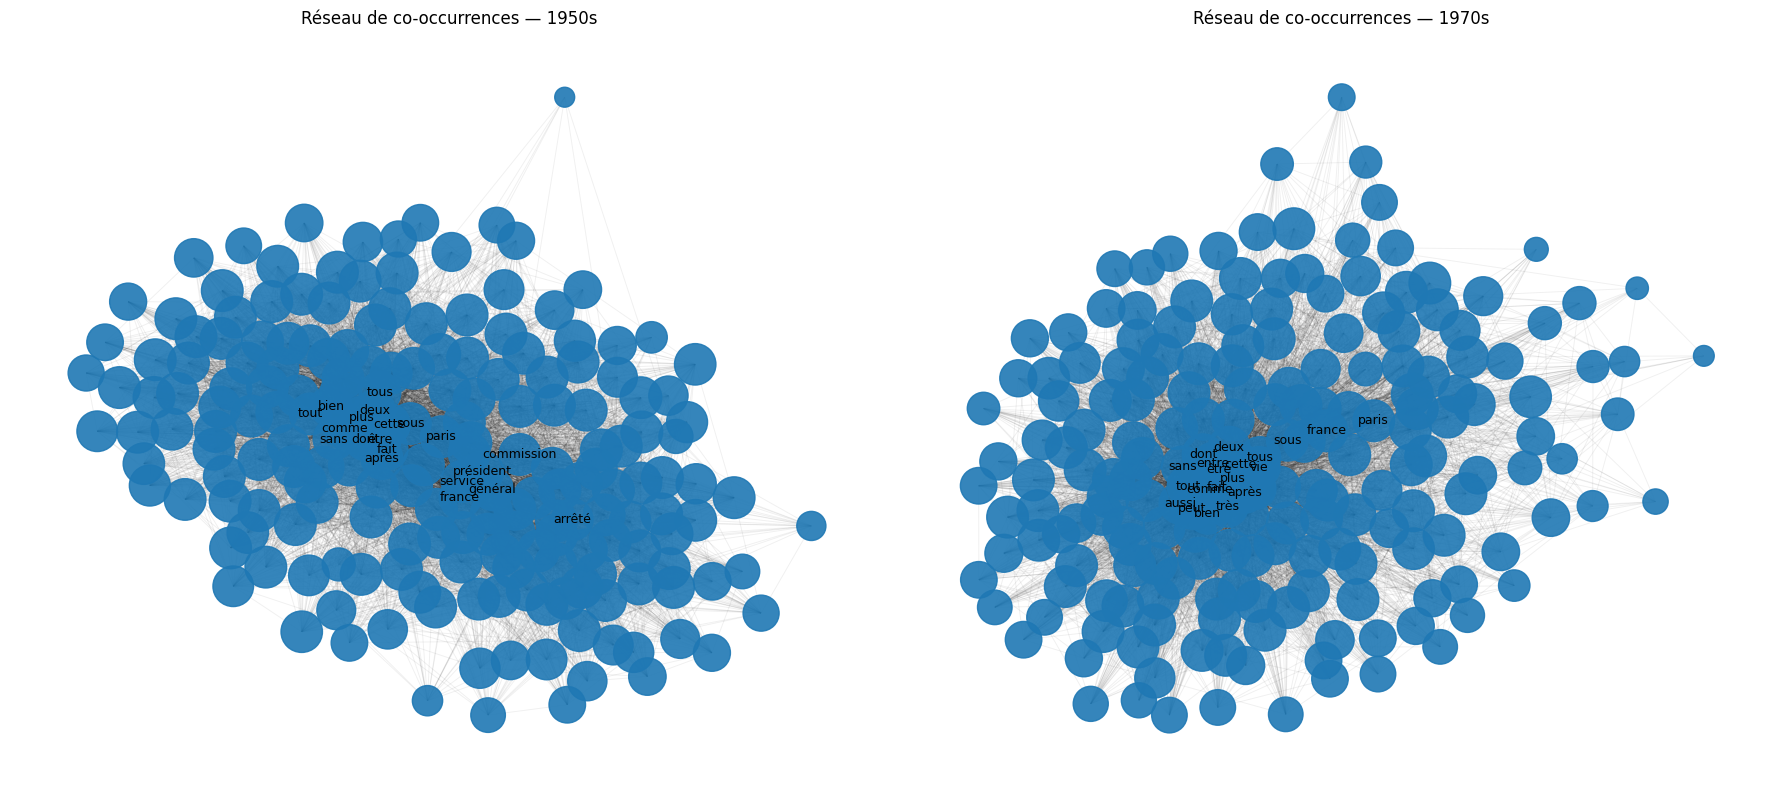

In [ ]:
# 21) Visualisation comparative : 1950s vs 1970s (réseaux côte à côte)
# Objectif : produire 2 graphes comparables visuellement

import matplotlib.pyplot as plt
import networkx as nx

if "graphs" not in globals():
    raise NameError("Variable 'graphs' introuvable. Lance d'abord la cellule 18.")

decades_to_compare = ["1950s", "1970s"]

plt.figure(figsize=(18, 8))

for i, dec in enumerate(decades_to_compare):
    G = graphs[dec]

    if G.number_of_nodes() == 0:
        print(f"Graphe vide pour {dec}")
        continue

    pos = nx.spring_layout(G, seed=42, k=0.35)

    # plot
    plt.subplot(1, 2, i + 1)

    # edges
    nx.draw_networkx_edges(G, pos, alpha=0.06, width=0.7)

    # nodes
    deg = dict(G.degree())
    sizes = [min(900, 80 + 18 * deg[n]) for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.9)

    # labels (20 mots les plus centraux)
    top_labels = [t for t, _ in sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]]
    labels = {t: t for t in top_labels}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    plt.title(f"Réseau de co-occurrences — {dec}")
    plt.axis("off")

plt.tight_layout()
plt.show()


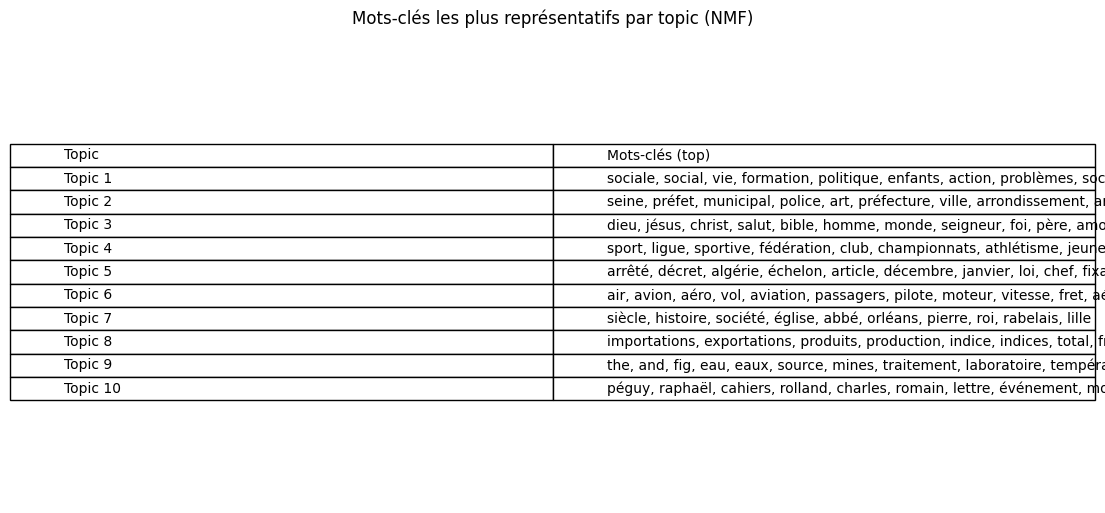

Fichier image créé : topic_keywords_table.png


In [ ]:
# 11bis) Visualisation des mots-clés par topic (table PNG)
# Objectif : produire une figure lisible pour les slides (topic -> mots-clés).

import matplotlib.pyplot as plt
import pandas as pd

# --- 1) Saisir / reconstruire le tableau des mots-clés (à partir de la sortie texte) ---
topics_keywords = {
    1: "sociale, social, vie, formation, politique, enfants, action, problèmes, sociaux, travailleurs, congrès",
    2: "seine, préfet, municipal, police, art, préfecture, ville, arrondissement, arrêté, publique, mairie",
    3: "dieu, jésus, christ, salut, bible, homme, monde, seigneur, foi, père, amour",
    4: "sport, ligue, sportive, fédération, club, championnats, athlétisme, jeunes, basket",
    5: "arrêté, décret, algérie, échelon, article, décembre, janvier, loi, chef, fixant",
    6: "air, avion, aéro, vol, aviation, passagers, pilote, moteur, vitesse, fret, aéronautique",
    7: "siècle, histoire, société, église, abbé, orléans, pierre, roi, rabelais, lille",
    8: "importations, exportations, produits, production, indice, indices, total, franc, trim, tonne",
    9: "the, and, fig, eau, eaux, source, mines, traitement, laboratoire, température, médecine",
    10: "péguy, raphaël, cahiers, rolland, charles, romain, lettre, événement, monsieur, bourgeois"
}

df_kw = pd.DataFrame(
    [{"Topic": f"Topic {k}", "Mots-clés (top)": v} for k, v in topics_keywords.items()]
)

# --- 2) Création d’une figure "table" ---
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis("off")

table = ax.table(
    cellText=df_kw.values,
    colLabels=df_kw.columns,
    cellLoc="left",
    colLoc="left",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)

plt.title("Mots-clés les plus représentatifs par topic (NMF)", pad=12)

# --- 3) Export PNG pour insertion dans PowerPoint ---
out_path = "topic_keywords_table.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("Fichier image créé :", out_path)
